In [7]:
import numpy as np
import torch
import torch.autograd as autograd         # computation graph
from torch import Tensor                  # tensor node in the computation graph
import torch.nn as nn                     # neural networks
import torch.optim as optim               # optimizers e.g. gradient descent, ADAM, etc.
import time
from pyDOE import lhs         #Latin Hypercube Sampling
import matplotlib.pyplot as plt
import matplotlib.ticker
import math
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

#Set default dtype to float32
torch.set_default_dtype(torch.float)

#PyTorch random number generator
torch.manual_seed(1234)

# Random number generators in other libraries
np.random.seed(1234)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(device)

if device == 'cuda': print(torch.cuda.get_device_name()) 

cpu


# Data Prep

Training and Testing data is prepared from the solution file

In [8]:
n = 32
x_1 = np.linspace(-1, 1, 2*n+1)
y_1 = np.linspace(1, 0, n+1)
z_1 = np.linspace(1, -1, 2*n+1)
Z_1, X_1, Y_1 = np.meshgrid(z_1, x_1, y_1)
x_2 = np.linspace(-1, 0, n+1)
y_2 = np.linspace(-1/n, -1, n)
Z_2, X_2, Y_2 = np.meshgrid(z_1, x_2, y_2)

x = np.vstack((X_1.flatten(order='F')[:, None], X_2.flatten(order='F')[:, None]))
y = np.vstack((Y_1.flatten(order='F')[:, None], Y_2.flatten(order='F')[:, None]))
z = np.vstack((Z_1.flatten(order='F')[:, None], Z_2.flatten(order='F')[:, None]))

# Test Data

We prepare the test data to compare against the solution produced by the PINN.

In [9]:
X_v_test = np.hstack((x, y, z))
v_true = x*y*(math.e**(x**2-1)-1)*(math.e**(y**2-1)-1)*np.sin(np.pi*z)
r = np.sqrt(x**2 + y**2)
theta = np.arctan2(y, x)
theta = np.where(theta < 0, theta + 2*np.pi, theta)
sd = r**(2/3) * np.sin(2*theta/3)
R = 1/2
etad = np.where(r < R, 15 / 16 * (
                    8 / 15 - (4 * r / R - 3) + 2 / 3 * (4 * r / R - 3) ** 3 - 1 / 5 * (4 * r / R - 3) ** 5), 0)
etad = np.where(r < R/2, 1, etad)

u_true = v_true + math.e**(-np.sqrt(2)*np.pi*r)*sd * etad * np.sin(np.pi*z)

lb = np.array([-1, -1, -1]) #lower bound
ub = np.array([1, 1, 1])  #upper bound

# Training Data

In [10]:
def trainingdata(N_v,N_f):
    
    x_1 = np.linspace(-1,1,2*n+1)
    x_3 = np.linspace((n-1)/n,-(n-1)/n,2*n-1)
    X, Z = np.meshgrid(x_1,x_3)
    edge1_x = np.hstack((X.flatten('F')[:,None], np.linspace(1,1,(2*n+1)*(2*n-1))[:,None], Z.flatten('F')[:,None]))
    edge1_v = np.linspace(0,0,(2*n+1)*(2*n-1))[:,None]
    
    x_3 = np.linspace((n-1)/n,-(n-1)/n,2*n-1)
    x_2 = np.linspace(0,(n-1)/n,n)
    Y, Z = np.meshgrid(x_2,x_3)
    edge2_x = np.hstack((np.linspace(1,1,n*(2*n-1))[:,None], Y.flatten('F')[:,None], Z.flatten('F')[:,None]))
    edge2_v = np.linspace(0,0,n*(2*n+1))[:,None]
    
    x_3 = np.linspace((n-1)/n,-(n-1)/n,2*n-1)
    x_1 = np.linspace(0,(n-1)/n,n)
    X, Z = np.meshgrid(x_1,x_3)
    edge3_x = np.hstack((X.flatten('F')[:,None], np.linspace(0,0,n*(2*n-1))[:,None], Z.flatten('F')[:,None]))
    edge3_v = np.linspace(0,0,n*(2*n-1))[:,None]
    
    x_3 = np.linspace((n-1)/n,-(n-1)/n,2*n-1)
    x_2 = np.linspace(-1,-1/n,n)
    Y, Z = np.meshgrid(x_2,x_3)
    edge4_x = np.hstack((np.linspace(0,0,n*(2*n-1))[:,None], Y.flatten('F')[:,None], Z.flatten('F')[:,None]))
    edge4_v = np.linspace(0,0,n*(2*n-1))[:,None]
    
    x_3 = np.linspace((n-1)/n,-(n-1)/n,2*n-1)
    x_1 = np.linspace(-1,-1/n,n)
    X, Z = np.meshgrid(x_1,x_3)
    edge5_x = np.hstack((X.flatten('F')[:,None], np.linspace(-1,-1,n*(2*n-1))[:,None], Z.flatten('F')[:,None]))
    edge5_v = np.linspace(0,0,n*(2*n-1))[:,None]
    
    x_3 = np.linspace((n-1)/n,-(n-1)/n,2*n-1)
    x_2 = np.linspace(-(n-1)/n,(n-1)/n,2*n-1)
    Y, Z = np.meshgrid(x_2,x_3)
    edge6_x = np.hstack((np.linspace(-1,-1,(2*n-1)**2)[:,None], Y.flatten('F')[:,None], Z.flatten('F')[:,None]))
    edge6_v = np.linspace(0,0,(2*n-1)**2)[:,None]
    
    x_1 = np.linspace(-1, 1, 2*n+1)
    y_1 = np.linspace(1, 0, n+1)
    Y_1, X_1 = np.meshgrid(y_1, x_1)
    x_2 = np.linspace(-1, 0, n+1)
    y_2 = np.linspace(-1/n, -1, n)
    Y_2, X_2 = np.meshgrid(y_2, x_2)
    x = np.vstack((X_1.flatten(order='F')[:, None], X_2.flatten(order='F')[:, None]))
    y = np.vstack((Y_1.flatten(order='F')[:, None], Y_2.flatten(order='F')[:, None]))
    
    edge7_x = np.hstack((x, y, np.linspace(-1,-1,(3*n+1)*(n+1))[:,None]))
    edge7_v = np.linspace(0,0,(3*n+1)*(n+1))[:,None]
    edge8_x = np.hstack((x, y, np.linspace(1,1,(3*n+1)*(n+1))[:,None]))
    edge8_v = edge7_v
    
    all_X_v_train = np.vstack([edge1_x, edge2_x, edge3_x, edge4_x, edge5_x, edge6_x, edge7_x, edge8_x])
    all_v_train = np.vstack([edge1_v, edge2_v, edge3_v, edge4_v, edge5_v, edge6_v, edge7_v, edge8_v])

    # choose random N_v points for training
    all_X_v_train_r = np.sqrt(all_X_v_train[:, 0]**2 + all_X_v_train[:, 1]**2)
    probability = np.where(all_X_v_train_r == 0, 0, 1)
    probability = probability / np.sum(probability)
    idx = np.random.choice(all_X_v_train.shape[0], N_v, replace=False, p=probability)
    X_v_train = all_X_v_train[idx[0:N_v], :]  # choose indices from  set 'idx' (x,t)
    v_train = all_v_train[idx[0:N_v], :]
    
    '''Collocation Points'''

    # N_f sets of tuples(x,t)
    probability = np.where(r == 0, 0, 1)
    probability = probability / np.sum(probability)
    idx = np.random.choice(X_v_test.shape[0], N_f, replace=False, p=probability.T[0])
    X_f = X_v_test[idx[0:N_f], :]

    X_f_train = np.vstack((X_f, X_v_train))  # append training points to collocation points

    return X_f_train, X_v_train, v_train

# SEPINN - nn

Creating sequential layers using the class
tf.Module

In [11]:
class Sequentialmodel(nn.Module):
    
    def __init__(self,layers,layers0):
        super().__init__() #call __init__ from parent class 
              
        'activation function'
        self.activation = nn.Tanh()

        'loss function'
        self.loss_function = nn.MSELoss(reduction ='mean')
    
        'Initialise neural network as a nn.MSELosslist using nn.Modulelist'  
        self.linears = nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers)-1)])
        self.linears0 = nn.ModuleList([nn.Linear(layers0[i], layers0[i+1]) for i in range(len(layers0)-1)])
        
        'Xavier Normal Initialization'
        # std = gain * sqrt(2/(input_dim+output_dim))
        for i in range(len(layers)-1):
            
            # weights from a normal distribution with 
            # Recommended gain value for tanh = 5/3?
            nn.init.xavier_normal_(self.linears[i].weight.data, gain=1.0)
            
            # set biases to zero
            nn.init.zeros_(self.linears[i].bias.data)
            
        for i in range(len(layers0)-1):
            
            # weights from a normal distribution with 
            # Recommended gain value for tanh = 5/3?
            nn.init.xavier_normal_(self.linears0[i].weight.data, gain=1.0)
            
            # set biases to zero
            nn.init.zeros_(self.linears0[i].bias.data)
            
    def forward(self,x):
        
        if torch.is_tensor(x) != True:         
            x = torch.from_numpy(x)                
        
        u_b = torch.from_numpy(ub).float().to(device)
        l_b = torch.from_numpy(lb).float().to(device)
                      
        #preprocessing input 
        x = (x - l_b)/(u_b - l_b) #feature scaling
        
        #convert to float
        a = x.float()
        
        for i in range(len(layers)-2):
            
            z = self.linears[i](a)
                        
            a = self.activation(z)
            
        a = self.linears[-1](a)
        
        return a
    
    def forward0(self,x):
        
        if torch.is_tensor(x) != True:         
            x = torch.from_numpy(x)                

        u_b = torch.from_numpy(ub).float().to(device)
        l_b = torch.from_numpy(lb).float().to(device)
                      
        #preprocessing input 
        x = (x - l_b)/(u_b - l_b) #feature scaling
        
        #convert to float
        a = x.float()
        
        for i in range(len(layers0)-2):
            
            z = self.linears0[i](a)
                        
            a = self.activation(z)
            
        a = self.linears0[-1](a)
        
        return a
                        
    def loss_BC(self,x,y):
        
        x_1_f = x[:,[0]]
        x_2_f = x[:,[1]]
        x_3_f = x[:,[2]]
        r = torch.sqrt(x_1_f ** 2 + x_2_f ** 2)
        theta = np.arctan2(x_2_f, x_1_f)
        theta = torch.where(theta < 0, theta + 2 * np.pi, theta)
        s = r**(2/3) * np.sin(2*theta/3)
        eta = torch.where(r < R, 15 / 16 * (8 / 15 - (8 * r - 3) + 2 / 3 * (8 * r - 3) ** 3 - 1 / 5 * (8 * r - 3) ** 5), 0)
        eta = torch.where(r < R/2, 1, eta)
        p = s * eta
        
        g = x.clone()
        
        g.requires_grad = True
        
        PHI = self.forward0(g)
        
        loss_v = self.loss_function(self.forward(g), - p * PHI)
        #loss_v = self.loss_function(self.forward(g), y)
                
        return loss_v
    
    def loss_PDE(self, x_to_train_f):
                
        x_1_f = x_to_train_f[:,[0]]
        x_2_f = x_to_train_f[:,[1]]
        x_3_f = x_to_train_f[:,[2]]
                        
        g = x_to_train_f.clone()
                        
        g.requires_grad = True
        
        vv = self.forward(g)
                
        v_x = autograd.grad(vv,g,torch.ones([x_to_train_f.shape[0], 1]).to(device), retain_graph=True, create_graph=True)[0]        
        v_xx = autograd.grad(v_x[:,[0]],g,torch.ones([x_to_train_f.shape[0], 1]).to(device), retain_graph=True, create_graph=True)[0]
        v_yy = autograd.grad(v_x[:,[1]],g,torch.ones([x_to_train_f.shape[0], 1]).to(device), retain_graph=True, create_graph=True)[0]
        v_zz = autograd.grad(v_x[:,[2]],g,torch.ones([x_to_train_f.shape[0], 1]).to(device), retain_graph=True, create_graph=True)[0]
        
        v_xx_1 = v_xx[:,[0]]
        v_xx_2 = v_yy[:,[1]]
        v_xx_3 = v_zz[:,[2]]
                        
        r = torch.sqrt(x_1_f ** 2 + x_2_f ** 2)
        theta = np.arctan2(x_2_f, x_1_f)
        theta = torch.where(theta < 0, theta + 2 * np.pi, theta)
        eta = torch.where(r < R, 15 / 16 * (8 / 15 - (8 * r - 3) + 2 / 3 * (8 * r - 3) ** 3 - 1 / 5 * (8 * r - 3) ** 5), 0)
        eta = torch.where(r < R/2, 1, eta)
        z = x_3_f
        
        p = math.e**(-np.sqrt(2)*np.pi*r) * r**(2/3) * np.sin(2*theta/3) * eta * np.sin(np.pi*z)
        deltap = torch.where(r < R, (r*(-0.222222222222222*(-7.5*r - 0.1875*(8*r - 3)**5 + 0.625*(8*r - 3)**3 + 3.3125)*np.sin(2*theta/3)*np.sin(np.pi*z)/(2.71828182845905**(np.sqrt(2)*np.pi*r)*r**1.33333333333333) + 1.33333333333333*(-7.5*(8*r - 3)**4 + 15.0*(8*r - 3)**2 - 7.5)*np.sin(2*theta/3)*np.sin(np.pi*z)/(2.71828182845905**(np.sqrt(2)*np.pi*r)*r**0.333333333333333) - 1.33333333333333*np.sqrt(2)*np.pi*(-7.5*r - 0.1875*(8*r - 3)**5 + 0.625*(8*r - 3)**3 + 3.3125)*np.sin(2*theta/3)*np.sin(np.pi*z)/(2.71828182845905**(np.sqrt(2)*np.pi*r)*r**0.333333333333333) + r**0.666666666666667*(1920.0*r - 240.0*(8*r - 3)**3 - 720.0)*np.sin(2*theta/3)*np.sin(np.pi*z)/2.71828182845905**(np.sqrt(2)*np.pi*r) - 2.0*np.sqrt(2)*np.pi*r**0.666666666666667*(-7.5*(8*r - 3)**4 + 15.0*(8*r - 3)**2 - 7.5)*np.sin(2*theta/3)*np.sin(np.pi*z)/2.71828182845905**(np.sqrt(2)*np.pi*r) + 2.0*np.pi**2*r**0.666666666666667*(-7.5*r - 0.1875*(8*r - 3)**5 + 0.625*(8*r - 3)**3 + 3.3125)*np.sin(2*theta/3)*np.sin(np.pi*z)/2.71828182845905**(np.sqrt(2)*np.pi*r)) + 0.666666666666667*(-7.5*r - 0.1875*(8*r - 3)**5 + 0.625*(8*r - 3)**3 + 3.3125)*np.sin(2*theta/3)*np.sin(np.pi*z)/(2.71828182845905**(np.sqrt(2)*np.pi*r)*r**0.333333333333333) + r**0.666666666666667*(-7.5*(8*r - 3)**4 + 15.0*(8*r - 3)**2 - 7.5)*np.sin(2*theta/3)*np.sin(np.pi*z)/2.71828182845905**(np.sqrt(2)*np.pi*r) - 1.0*np.sqrt(2)*np.pi*r**0.666666666666667*(-7.5*r - 0.1875*(8*r - 3)**5 + 0.625*(8*r - 3)**3 + 3.3125)*np.sin(2*theta/3)*np.sin(np.pi*z)/2.71828182845905**(np.sqrt(2)*np.pi*r))/r - 4*(-7.5*r - 0.1875*(8*r - 3)**5 + 0.625*(8*r - 3)**3 + 3.3125)*np.sin(2*theta/3)*np.sin(np.pi*z)/(9*2.71828182845905**(np.sqrt(2)*np.pi*r)*r**1.33333333333333) - np.pi**2*r**0.666666666666667*(-7.5*r - 0.1875*(8*r - 3)**5 + 0.625*(8*r - 3)**3 + 3.3125)*np.sin(2*theta/3)*np.sin(np.pi*z)/2.71828182845905**(np.sqrt(2)*np.pi*r), 0)
        deltap = torch.where(r < R / 2, (r*(-0.222222222222222*np.sin(2*theta/3)*np.sin(np.pi*z)/(2.71828182845905**(np.sqrt(2)*np.pi*r)*r**1.33333333333333) - 1.33333333333333*np.sqrt(2)*np.pi*np.sin(2*theta/3)*np.sin(np.pi*z)/(2.71828182845905**(np.sqrt(2)*np.pi*r)*r**0.333333333333333) + 2.0*np.pi**2*r**0.666666666666667*np.sin(2*theta/3)*np.sin(np.pi*z)/2.71828182845905**(np.sqrt(2)*np.pi*r)) + 0.666666666666667*np.sin(2*theta/3)*np.sin(np.pi*z)/(2.71828182845905**(np.sqrt(2)*np.pi*r)*r**0.333333333333333) - 1.0*np.sqrt(2)*np.pi*r**0.666666666666667*np.sin(2*theta/3)*np.sin(np.pi*z)/2.71828182845905**(np.sqrt(2)*np.pi*r))/r - 4*np.sin(2*theta/3)*np.sin(np.pi*z)/(9*2.71828182845905**(np.sqrt(2)*np.pi*r)*r**1.33333333333333) - np.pi**2*r**0.666666666666667*np.sin(2*theta/3)*np.sin(np.pi*z)/2.71828182845905**(np.sqrt(2)*np.pi*r), deltap)
        
        f = -(4*x_1_f**3+6*x_1_f)*x_2_f*math.e**(x_1_f**2-1)*(math.e**(x_2_f**2-1)-1)*np.sin(np.pi*z)-(4*x_2_f**3+6*x_2_f)*x_1_f*math.e**(x_2_f**2-1)*(math.e**(x_1_f**2-1)-1)*np.sin(np.pi*z)+2*np.pi**2*x_1_f*x_2_f*(math.e**(x_1_f**2-1)-1)*(math.e**(x_2_f**2-1)-1)*np.sin(np.pi*z)-deltap+np.pi**2*p
        
        s = r**(2/3) * np.sin(2*theta/3)
        eta = torch.where(r < R, 15 / 16 * (8 / 15 - (8 * r - 3) + 2 / 3 * (8 * r - 3) ** 3 - 1 / 5 * (8 * r - 3) ** 5), 0)
        eta = torch.where(r < R/2, 1, eta)
        p = s * eta
        
        deltap0 = torch.where(r < R,
                          -4 * (-7.5 * r - 0.1875 * (8 * r - 3) ** 5 + 0.625 * (8 * r - 3) ** 3 + 3.3125) * np.sin(
                              2 * theta / 3) / (9 * r ** (4 / 3)) + (2 / 3 * (
                                  -7.5 * r - 0.1875 * (8 * r - 3) ** 5 + 0.625 * (
                                  8 * r - 3) ** 3 + 3.3125) * np.sin(2 * theta / 3) / r ** (1 / 3) + r ** (
                                                                             2 / 3) * (
                                                                             -7.5 * (8 * r - 3) ** 4 + 15.0 * (
                                                                             8 * r - 3) ** 2 - 7.5) * np.sin(
                              2 * theta / 3) + r * (-2 / 9 * (-7.5 * r - 0.1875 * (8 * r - 3) ** 5 + 0.625 * (
                                  8 * r - 3) ** 3 + 3.3125) * np.sin(2 * theta / 3) / r ** (4 / 3) + 4 / 3 * (
                                                            -7.5 * (8 * r - 3) ** 4 + 15.0 * (
                                                            8 * r - 3) ** 2 - 7.5) * np.sin(
                              2 * theta / 3) / r ** (1 / 3) + r ** (2 / 3) * (
                                                            1920.0 * r - 240.0 * (8 * r - 3) ** 3 - 720.0) * np.sin(
                              2 * theta / 3))) / r, 0)
        deltap0 = torch.where(r < R / 2, 0, deltap0)
        
        p_r = torch.where(r < R, 0.625*(-8*r - 0.2*(8*r - 3)**5 + 0.666666666666667*(8*r - 3)**3 + 3.53333333333333)*np.sin(2*theta/3)/r**0.333333333333333 + 15*r**0.666666666666667*(-8.0*(8*r - 3)**4 + 16.0*(8*r - 3)**2 - 8)*np.sin(2*theta/3)/16, 0)
        p_r = torch.where(r < R / 2, 0.666666666666667*np.sin(2*theta/3)/r**0.333333333333333, p_r)
        p_theta = 2/3* eta * r**(2/3) * np.cos(2*theta/3)
        
        PHI = self.forward0(g)
        PHI_x = autograd.grad(PHI,g,torch.ones([x_to_train_f.shape[0], 1]).to(device), retain_graph=True, create_graph=True)[0]        
        
        PHI_x_1 = PHI_x[:,[0]]
        PHI_x_2 = PHI_x[:,[1]]
        PHI_x_3 = PHI_x[:,[2]]
        
        PHI_xx = autograd.grad(PHI_x_1,g,torch.ones([x_to_train_f.shape[0], 1]).to(device), retain_graph=True, create_graph=True)[0]
        PHI_yy = autograd.grad(PHI_x_2,g,torch.ones([x_to_train_f.shape[0], 1]).to(device), retain_graph=True, create_graph=True)[0]
        PHI_zz = autograd.grad(PHI_x_3,g,torch.ones([x_to_train_f.shape[0], 1]).to(device), retain_graph=True, create_graph=True)[0]
        
        PHI_xx_1 = PHI_xx[:,[0]]
        PHI_xx_2 = PHI_yy[:,[1]]
        PHI_xx_3 = PHI_zz[:,[2]]
        
        deltaPHI = PHI_xx_1 + PHI_xx_2 + PHI_xx_3
        
        F = v_xx_1 + v_xx_2 + v_xx_3 - np.pi**2*vv + f + deltap0 * PHI + 2 * (p_r * x_1_f/r * PHI_x_1 + p_r* x_2_f/r * PHI_x_2)+ 2*p_theta*(-x_2_f* PHI_x_1 + x_1_f * PHI_x_2)/r**2 + p * deltaPHI - np.pi**2 * PHI * p
        
        loss_f = self.loss_function(F, f_hat)
        
        return loss_f
    
    def loss(self,x,y,x_to_train_f,sigma):

        loss_v = self.loss_BC(x,y)
        loss_f = self.loss_PDE(x_to_train_f)

        loss = sigma * loss_v + loss_f

        return loss
     
    'callable for optimizer'                                       
    def closure(self):
        
        optimizer.zero_grad()
        
        loss_val = self.loss(X_v_train, v_train, X_f_train, sigma)
        
        #error_vec, _ = PINN.test()
        
        #print(loss_val,error_vec)
        
        loss_val.backward()

        return loss_val        
    
    def test(self):
                
        v_pred = self.forward(X_v_test_tensor)
        
        PHI_pred = self.forward0(X_v_test_tensor)
        
        error_vec = torch.linalg.norm((v-v_pred),2)/torch.linalg.norm(v,2)        # Relative L2 Norm of the error (Vector)
        
        u_pred = v_pred.cpu().detach().numpy() + PHI_pred.cpu().detach().numpy() * sd * etad

        return error_vec, u_pred

# Loss Function

The loss function consists of two parts:

    loss_BC: MSE error of boundary losses
    loss_PDE: MSE error of collocation points satisfying the PDE

loss = loss_BC + loss_PDE


Sequentialmodel(
  (activation): Tanh()
  (loss_function): MSELoss()
  (linears): ModuleList(
    (0): Linear(in_features=3, out_features=20, bias=True)
    (1): Linear(in_features=20, out_features=20, bias=True)
    (2): Linear(in_features=20, out_features=20, bias=True)
    (3): Linear(in_features=20, out_features=1, bias=True)
  )
  (linears0): ModuleList(
    (0): Linear(in_features=3, out_features=10, bias=True)
    (1): Linear(in_features=10, out_features=10, bias=True)
    (2): Linear(in_features=10, out_features=10, bias=True)
    (3): Linear(in_features=10, out_features=1, bias=True)
  )
)
tensor(0.0701, grad_fn=<DivBackward0>)
tensor(0.0324, grad_fn=<DivBackward0>)
tensor(0.0267, grad_fn=<DivBackward0>)
tensor(0.0267, grad_fn=<DivBackward0>)
tensor(0.0255, grad_fn=<DivBackward0>)
tensor(0.0255, grad_fn=<DivBackward0>)
Training time: 1631.33
sigma: 3037.500000
Test Error: 0.02553


C:\Users\HP\AppData\Local\Temp/ipykernel_3076/2431657845.py:93: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolor(X, Y, u_sol_0, cmap='jet')
C:\Users\HP\AppData\Local\Temp/ipykernel_3076/2431657845.py:102: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolor(X, Y, u_pred_0, cmap='jet')
C:\Users\HP\AppData\Local\Temp/ipykernel_3076/2431657845.py:111: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecat

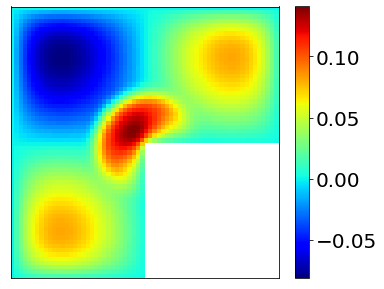

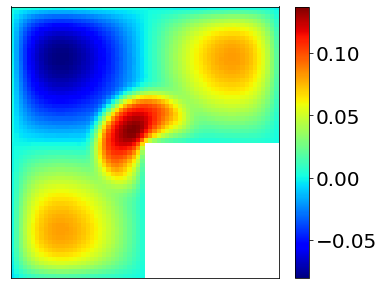

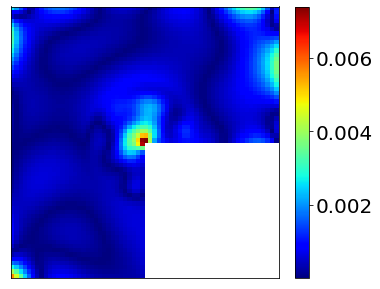

In [12]:
N_v = 800
N_f = 10000

X_f_train_np_array, X_v_train_np_array, v_train_np_array = trainingdata(N_v,N_f)

'Convert to tensor and send to GPU'
X_f_train = torch.from_numpy(X_f_train_np_array).float().to(device)
X_v_train = torch.from_numpy(X_v_train_np_array).float().to(device)
#v_train = torch.zeros(X_v_train.shape[0],1).to(device)
v_train = torch.from_numpy(v_train_np_array).float().to(device)
X_v_test_tensor = torch.from_numpy(X_v_test).float().to(device)
v = torch.from_numpy(v_true).float().to(device)
u = torch.from_numpy(u_true).float().to(device)
f_hat = torch.zeros(X_f_train.shape[0],1).to(device)

layers = np.array([3,20,20,20,1])
layers0 = np.array([3,10,10,10,1])

PINN = Sequentialmodel(layers,layers0)
       
PINN.to(device)

'Neural Network Summary'

print(PINN)

params = list(PINN.parameters())

sigma = 400

start_time = time.time()
error_vec = 1

while sigma<4000 and error_vec>0.01:
    optimizer = torch.optim.LBFGS(PINN.parameters(), lr=0.15,
                              max_iter = 5000, 
                              max_eval = None, 
                              tolerance_grad = 1e-06, 
                              tolerance_change = 1e-09, 
                              history_size = 100, 
                              line_search_fn = 'strong_wolfe')

    optimizer.zero_grad()     # zeroes the gradient buffers of all parameters
    optimizer.step(PINN.closure)
    sigma = 1.5 * sigma
    error_vec, _ = PINN.test()
    print(error_vec)

elapsed = time.time() - start_time                
print('Training time: %.2f' % (elapsed))

''' Model Accuracy ''' 
error_vec, u_pred = PINN.test()

print('sigma: %f' %(sigma/1.5))
print('Test Error: %.5f'  % (error_vec))

# Plotting
xx = np.linspace(-1, 1, 2*n+1)
yy = np.linspace(1, -1, 2*n+1)
Y, X = np.meshgrid(yy, xx)
for i in range(2*n+1):
    for j in range(2*n+1):
        if X[i, j] > 0 and Y[i, j] < 0:
            X[i, j] = float('nan')
            Y[i, j] = float('nan')

m=n//2
u_sol_0 = u_true[m*(2*n+1):(m+1)*(2*n+1),:]
for k in range(1,n+1):
    u_sol_0 = np.vstack((u_sol_0, u_true[k*(2*n+1)**2+m*(2*n+1):k*(2*n+1)**2+(m+1)*(2*n+1),:]))
for k in range(n+1,2*n+1):
    u_sol_0 = np.vstack((u_sol_0, u_true[(n+1)*(2*n+1)**2+(k-(n+1))*(n+1)*(2*n+1)+m*(n+1):(n+1)*(2*n+1)**2+(k-(n+1))*(n+1)*(2*n+1)+(m+1)*(n+1),:]))

for i in range(n+1, 2*n+1):      # to supplement 0 to the 4th quadrant
    for j in range(n+1, 2*n+1):
        u_sol_0 = np.insert(u_sol_0, i*(2*n+1)+j, 0)
u_sol_0 = np.reshape(u_sol_0, (2*n+1, 2*n+1), order='F')    

u_pred_0 = u_pred[m*(2*n+1):(m+1)*(2*n+1),:]
for k in range(1,n+1):
    u_pred_0 = np.vstack((u_pred_0, u_pred[k*(2*n+1)**2+m*(2*n+1):k*(2*n+1)**2+(m+1)*(2*n+1),:]))
for k in range(n+1,2*n+1):
    u_pred_0 = np.vstack((u_pred_0, u_pred[(n+1)*(2*n+1)**2+(k-(n+1))*(n+1)*(2*n+1)+m*(n+1):(n+1)*(2*n+1)**2+(k-(n+1))*(n+1)*(2*n+1)+(m+1)*(n+1),:]))

for i in range(n+1, 2*n+1):      # to supplement 0 to the 4th quadrant
    for j in range(n+1, 2*n+1):
        u_pred_0 = np.insert(u_pred_0, i*(2*n+1)+j, 0)
u_pred_0 = np.reshape(u_pred_0, (2*n+1, 2*n+1), order='F')    

# True
fig_1 = plt.figure(1, figsize=(6, 5))
plt.pcolor(X, Y, u_sol_0, cmap='jet')
h=plt.colorbar()
h.ax.tick_params(labelsize=20)
plt.xticks([])
plt.yticks([])
plt.savefig('true-5-nn',bbox_inches='tight')

# Prediction
fig_2 = plt.figure(2, figsize=(6, 5))
plt.pcolor(X, Y, u_pred_0, cmap='jet')
h=plt.colorbar()
h.ax.tick_params(labelsize=20)
plt.xticks([])
plt.yticks([])
plt.savefig('pred-5-nn',bbox_inches='tight')

# Error
fig_3 = plt.figure(3, figsize=(6, 5))
plt.pcolor(X, Y, np.abs(u_sol_0 - u_pred_0), cmap='jet')
h=plt.colorbar()
h.ax.tick_params(labelsize=20)
plt.xticks([])
plt.yticks([])
plt.savefig('error-5-nn',bbox_inches='tight')